Comparison of simulationed XYZ and transformed XYZ using Sovdat2019 matrix eq8 and eq 9


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

current_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from src import *
sys.path.append(os.path.join(current_dir,'..','params'))
from load_params import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Ecostress simulation eval
ds_xyz = read_csv(os.path.join(current_dir,'..','Simulation','xyz_ECOSTRESS.csv'))
ds_rho_s2a = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2A.csv'))
ds_rho_s2b = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2B.csv'))
ds_rho_s2 = [ds_rho_s2a,ds_rho_s2b]
s2_bnames = ['B4','B3','B2']
xyz_names = ['X','Y','Z']
sensor_names = ['S2A','S2B']

# load test fname list
f = open(os.path.join(current_dir,'..','Simulation','fnames_test.txt'),"r")
fnames_test = f.read().splitlines()
f.close()

def get_inds(fnames,fnames_sub):
    inds = []
    for fname in fnames_sub:
        inds.append(fnames.index(fname))
    return inds

inds = get_inds(ds_xyz['NAME'],fnames_test)

def build_sub_dataset(ds,inds):
    mydict = {}
    for key in list(ds.keys()):
        mydict[key] = np.array(ds[key])[inds]
    return mydict

ds_xyz_sub = build_sub_dataset(ds_xyz,inds)

ds_rho_s2_sub = []
for ds in ds_rho_s2:
    ds_rho_s2_sub.append(build_sub_dataset(ds,inds))


Eq8
RMSE = 0.00948,0.00386,0.02146
R2 = 0.98590,0.99779,0.93449


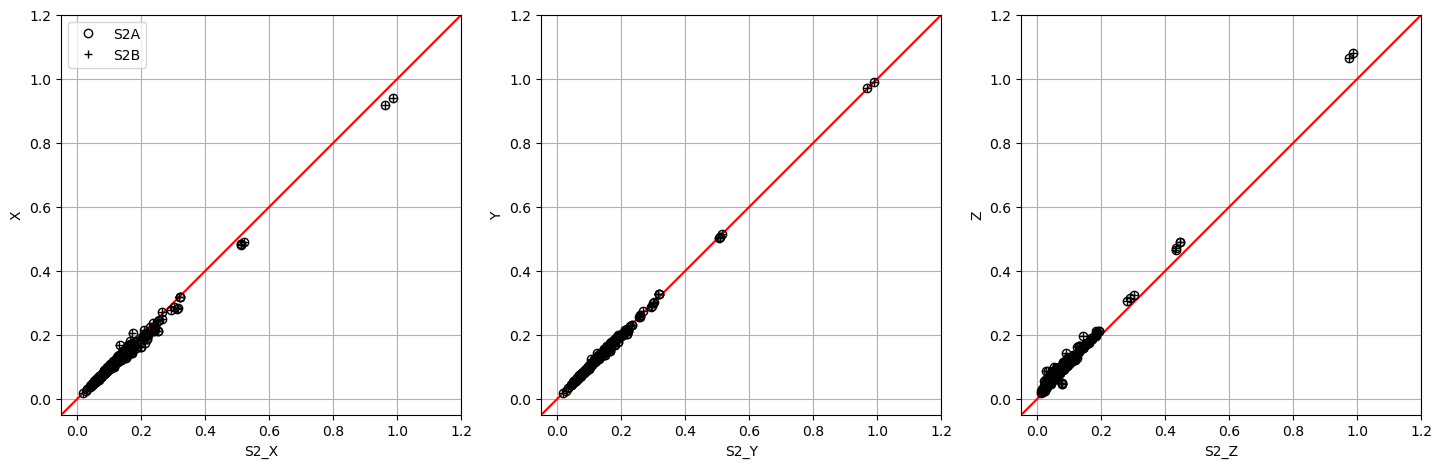

Eq8 new
RMSE = 0.00620,0.00342,0.01218
R2 = 0.99397,0.99826,0.97889


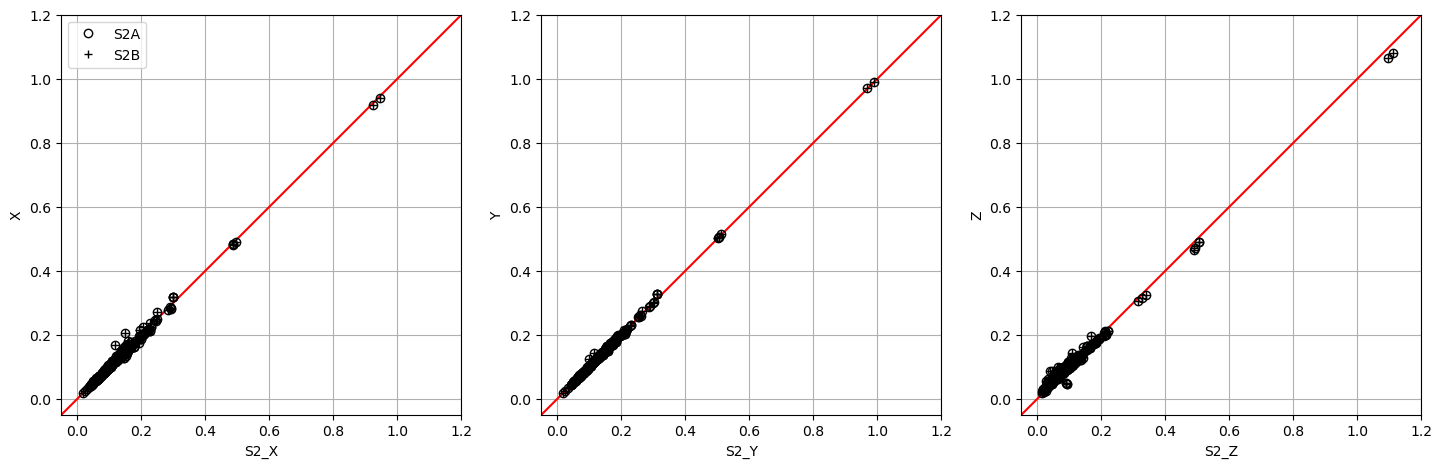

In [9]:
def s2_to_xyz(ds_s2,matrix):
    s2_bnames = ['B4','B3','B2']
    A = np.empty([len(ds_s2['B4']),3],dtype=float)
    for i in range(len(s2_bnames)):
            A[:,i] = ds_s2[s2_bnames[i]]
    B = A @ matrix
    
    return B

def metrics(ds_s2,ds_xyz,matrixs):
    
    xyz_s2 = []
    for s in range(2):
        xyz = s2_to_xyz(ds_s2[s],matrixs[s])
        xyz_s2.append(xyz)
    
    xyz_names = ['X','Y','Z']
    m = len(ds_xyz['X'])
    B = np.empty([m*2,3],dtype=float)
    B1 = np.empty_like(B)
    for i in range(3):
        for s in range(2):
            y = ds_xyz[xyz_names[i]]
            y1 = xyz_s2[s][:,i]
            B[s*m:s*m+m,i] = y
            B1[s*m:s*m+m,i] = y1
    # RMSE for xyz
    rmse_xyz = []
    r2_xyz = []
    for i in range(3):
        y1 = B1[:,i]
        y = B[:,i]
        rmse = np.sqrt(np.mean((y-y1)**2))
        r2 = 1- np.sum((y-y1)**2)/np.sum((y-np.mean(y))**2)
        rmse_xyz.append(rmse)
        r2_xyz.append(r2)
    print('RMSE = {:.5f},{:.5f},{:.5f}'.format(rmse_xyz[0],rmse_xyz[1],rmse_xyz[2]))
    print('R2 = {:.5f},{:.5f},{:.5f}'.format(r2_xyz[0],r2_xyz[1],r2_xyz[2]))

def plot_scatter(ds_s2,ds_xyz,matrixs,dstfile=None):
    xyz_s2 = []
    for s in range(2):
        xyz = s2_to_xyz(ds_s2[s],matrixs[s])
        xyz_s2.append(xyz)

    X = []
    Y = []
    for i in range(3):
        xs = []
        ys = []
        xs.append([-0.05,1.2])
        ys.append([-0.05,1.2])
        for s in range(2):
            x = list(xyz_s2[s][:,i])
            y = ds_xyz[xyz_names[i]]
            xs.append(x)
            ys.append(y)
        X.append(xs)
        Y.append(ys)

    xlabels = ['S2_X','S2_Y','S2_Z']
    ylabels = ['X','Y','Z']
    legends = [['','S2A','S2B'],None,None]
    fmts = [['r-','ko','k+']]*len(s2_bnames)
    solid_markers = [[False,False,False]]*len(X)
    grid = [True]*len(X)
    xlims = [(-0.05,1.2)]*len(X)
    # xlims = None
    ylims = xlims
    plot_figures(X, Y, xlabels=xlabels, ylabels=ylabels, titles=None, ncol=3, cell_width=4, cell_height=4,
                     left_margin=0.5, right_margin=0.5, top_margin=0.5, bottom_margin=0.5,
                     h_margin=0.8, v_margin=0.5, fmts=fmts, grid=grid, solid_markers=solid_markers, 
                     legends=legends, dstfile=dstfile,xlims=xlims,ylims=ylims)


print('Eq8')
matrix = matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8
metrics(ds_rho_s2_sub,ds_xyz_sub,[matrix,matrix])
plot_scatter(ds_rho_s2_sub,ds_xyz_sub,[matrix,matrix],dstfile=None)
print('Eq8 new')
matrix = matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new
metrics(ds_rho_s2_sub,ds_xyz_sub,[matrix,matrix])
plot_scatter(ds_rho_s2_sub,ds_xyz_sub,[matrix,matrix],dstfile=None)

